<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/HelmerNylen/Lab-6/HelmerNylen_lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 6: Differential Equations**
**Helmer Nylén**

# **Abstract**

We implement the explicit Euler method for ODEs and stochastic DEs, both for scalars and vectors. We test the implementations for accuracy and stability, and while the ODE version works as expected the SDE version may be biased.

#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [1005]:
"""This program is a lab report in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2019 Helmer Nylén (helmern@kth.se)
# Some elements of the lab were discussed with Jonas Nylund and Christoffer Ejemyr

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [0]:
# Load neccessary modules.
import time
import numpy as np
import numpy.polynomial.polynomial as P
from numbers import Number

from matplotlib import pyplot as plt
from matplotlib import tri, animation, rc, axes
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, HTML

# **Introduction**

Finding the analytical solution of a differential equation can be hard, even more so when there are multiple variables involved. In this lab we implement methods to approximate the solutions of differential equations given a starting value and an expression for the time derivative. We implement the explicit Euler method both for ordinary differential equations and stochastic differential equations in one and more variables and test them.


# **Methods**

## Ordinary differential equation

To produce the time stepping approximation we use the explicit Euler method described in algorithm 13.1, chapter 13.2 (assuming line 2 should read `for i=0:no_subintervals-1 do`). We solve both assignment 1 and 2 using the same method `euler_forward`.

In [0]:
# Helper function for the main loop
def enumerate_keep(iterable):
  _iter = iter(iterable)
  last = next(_iter)
  i = 1
  for item in _iter:
    yield i, item, last
    last = item
    i += 1

def euler_forward(T, f, u0, m = 100, return_times = False):
  assert T > 0 and hasattr(f, "__call__") and m > 1
  
  # If f and u0 are scalar, treat them as arrays of length 1 and then cast back
  u0_scalar = isinstance(u0, Number)
  if u0_scalar:
    u0 = np.array([u0])
    try:
      _ = f(u0, 0)
    except:
      f = lambda u, t: f(u[0], t)
  else:
    u0 = np.array(u0)
  assert np.array(f(u0, 0)).shape == u0.shape \
         or (u0.shape == (1,) and isinstance(f(u0, 0), Number))
  
  n = len(u0)
  U = np.zeros((n, m))
  U[:, 0] = u0
  times = np.linspace(0, T, m)

  for i, t, t_last in enumerate_keep(times):
    U[:, i] = U[:, i - 1] + (t - t_last) * f(U[:, i - 1], t)
  
  if u0_scalar:
    U = np.reshape(U, (m,))
  if return_times:
    return (times, U)
  else:
    return U

The following method is used to produce animations of the time steppings.

In [0]:
# Based on http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/

def animate(times, U, logplot=False, timescale = 1, title = None):
  fig, ax = plt.subplots()

  if U.shape[0] == 2:
    ax.set_xlim((U.min(), U.max()))
    ax.set_ylim((U.min(), U.max()))
    if logplot:
      ax.set_yscale('log')
    ax.set_xlabel("$U_0(t)$")
    ax.set_ylabel("$U_1(t)$")
    line, = ax.plot([], [])
    point, = ax.plot([], [], 'o')
    def _init():
      point.set_data([], [])
      line.set_data([], [])
      return point, line
    
    def _animate(i):
      point.set_data(U[0, i], U[1, i])
      line.set_data(U[0, :i+1], U[1, :i+1])
      return point, line

  else:
    ax.set_xlim((-0.5, U.shape[0] - 0.5))
    ax.set_ylim((U.min(), U.max()))
    if logplot:
      ax.set_yscale('log')
    ax.set_xlabel("Dimension $i$")
    ax.set_ylabel("$U_i(t)$")
    ax.set_xticks(range(U.shape[0]))

    line, = ax.plot([], [], 'o')
    def _init():
      line.set_data([], [])
      return line,

    def _animate(i):
      line.set_data(range(U.shape[0]), U[:, i])
      return line,
  if title:
    fig.suptitle(title)
  a = animation.FuncAnimation(fig, _animate, init_func=_init,
                                  frames=len(times), blit=True,
                                  interval = 1000 * (times[1] - times[0]) / timescale)
  plt.close(fig)
  return HTML(a.to_html5_video())

To test the implementation we verify it against differential equations with known solutions for both accuracy and stability. For the accuracy test we let $$\frac{du}{dt} = p(t) = \sum_{i=0}^n c_i x^i,\ u_0 = 0,$$ for which we know the solution to be $$P(t) = \sum_{i=0}^{n+1} \frac{c_{i-1}}{i} x^i.$$ We let the simulation run between 0 and $T$ using $m$ linearly spaced points, and look at the integral of the residual as $m$ is varied. We expect it to decrease as we increase $m$.

For stability we use the system $$\frac{du}{dt} = a u(t),$$ where $a<0$ is a real number. Trivially, $u(t=0) = 0$ is a stable point for the system and we verify that a small disturbance $u(t=0) = \epsilon$ converges towards it; i.e. that $$\lim_{t\rightarrow \infty} u(t) = 0.$$ In practice, for simplicity we check that $u(T = 100)$ is sufficiently small for $a \in [-5, -0.25]$ but we can check $a$ arbitrarily close to 0 by increasing $T$.

In [0]:
# Approximation class reused from lab 4
class Approx:
  def __init__(self, data, mesh):
    self.data = data
    self.mesh = mesh
  
  def __call__(self, x):
    if type(x) is np.ndarray:
      return np.array([self(xi) for xi in x])
    assert self.mesh[0] <= x <= self.mesh[-1]
    if x == self.mesh[-1]:
      return self.data[-1]
    
    i = (self.mesh <= x).nonzero()[0][-1]
    t = (x - self.mesh[i]) / (self.mesh[i+1] - self.mesh[i])
    return self.data[i] + (self.data[i+1] - self.data[i]) * t

def test_scalar():
  # Accuracy
  deg = 3
  c = np.random.choice([-1, 1], deg + 1) * np.exp((deg + 1) * (np.random.rand(deg + 1) - 0.5) / (1 + np.arange(deg + 1)))
  f = lambda u, t: P.polyval(t, c)
  u0 = 0
  print("U(x) = " + " + ".join([f"{_c:.2f} * x^{i}" for i, _c in enumerate(P.polyint(c))]))

  all_times, all_U = [], []
  error = []
  T = 3
  fine_times = np.linspace(0, T, 3000)
  r = range(10, 1010, 100)
  for m in r:
    times, U = euler_forward(T, f, u0, m = m, return_times=True)
    all_times.append(times)
    all_U.append(U)
    if m == r[0]:
      plt.figure()
      plt.plot(times, U)
      plt.plot(times, P.polyval(times, P.polyint(c)))
      plt.title("Function")
      plt.xlabel("$t$")
      plt.ylabel("$|U(t)|$")
      plt.legend((f"Approximation ({r[0]} time steps)", "Exact"))
      plt.show()
    approx = Approx(U, times)
    error.append(sum(np.abs(approx(fine_times) - P.polyval(fine_times, P.polyint(c)))))

  plt.figure()
  plt.semilogy(r, error)
  plt.xlabel("Time steps")
  plt.ylabel("$c\int_0^T |U_{approx}(t)-U_{exact}(t)|dt$")
  plt.title("Total residual")
  plt.show()

  # Stability
  a = -4.75 * np.random.rand() - 0.25
  f = lambda u, t: a * u
  u0 = (np.random.rand() - 0.5) * 0.2
  times, U = euler_forward(100, f, u0, m = 2000, return_times = True)

  print(f"a: {a:.3}, \\epsilon: {u0:.3}")
  plt.figure()
  plt.semilogy(times, abs(U))
  plt.xlabel("$t$")
  plt.ylabel("$|U(t)|$")
  plt.title("Stability")
  plt.show()
  assert np.isclose(0, U[-1])

Using the same idea as above for the for the system of equations we test against the system $$\frac{du}{dt} = \begin{bmatrix}-u_1(t) \\ u_0(t)\end{bmatrix},\ u(t=0) = \begin{bmatrix}1 \\ 0\end{bmatrix}.$$ This has the exact solution $$u(t) = \begin{bmatrix}\cos x \\ \sin x\end{bmatrix}$$ with the property that $|u(t)| = 1$. We expect the error in $|u(t)|$ to increase faster in $t$ as we decrease the number of time steps $m$.

For stability we use the system $$\frac{du}{dt} = a\begin{bmatrix}u_0(t) \\ u_1(t)\end{bmatrix}$$ where $a<0$ is a real number, which has a stable point in $$u(t=0) = \vec{0}.$$ Analogously to above we verify that a small disturbance $u(t=0) = \epsilon \begin{bmatrix}\cos \theta \\ \sin \theta\end{bmatrix}$ converges towards $\vec{0}$.

In [0]:
def test_system():
  # Accuracy
  f = lambda u, t: np.array([-u[1], u[0]])
  u0 = [1, 0]
  t1, U1 = euler_forward(20, f, u0, return_times = True)
  plt.figure()
  plt.plot(U1[0, :], U1[1, :])
  t2, U2 = euler_forward(20, f, u0, m = 500, return_times = True)
  plt.plot(U2[0, :], U2[1, :])
  U3 = np.array([np.cos(t2), np.sin(t2)])
  plt.plot(U3[0, :], U3[1, :])
  plt.xlabel("$U_0(t)$")
  plt.ylabel("$U_1(t)$")
  plt.title("Curve")
  plt.legend(("100 points", "500 points", "Exact solution"))
  plt.show()

  display(animate(t2, U2, title = "500 points"))

  plt.figure()
  plt.plot(t1, np.linalg.norm(U1, axis=0) - np.linalg.norm(np.array([np.cos(t1), np.sin(t1)]), axis=0))
  plt.plot(t2, np.linalg.norm(U2, axis=0) - np.linalg.norm(U3, axis=0))
  plt.xlabel("$t$")
  plt.ylabel("$||U(t)| - U_0|$")
  plt.title("Residual of amplitude")
  plt.legend(("100 points", "500 points"))
  plt.show()

  # Stability
  a = -4.75 * np.random.rand() - 0.25
  f = lambda u, t: a * u
  theta = np.random.rand() * 2 * np.pi
  u0 = np.random.rand() * 0.1 * np.array([np.cos(theta), np.sin(theta)])
  times, U = euler_forward(100, f, u0, m = 2000, return_times = True)

  print(f"a: {a:.3}, \\epsilon: {np.linalg.norm(u0):.3}, \\theta: {theta:.3}")
  plt.figure()
  plt.semilogy(times, np.linalg.norm(U, axis=0))
  plt.xlabel("$t$")
  plt.ylabel("$|U(t)|$")
  plt.title("Stability")
  plt.show()
  assert np.isclose(0, np.linalg.norm(U[:, -1]))

## Stochastic differential equation

For the implementation of stochastic differential equations we base the method on the above explicit Euler, and use the update step in the penultimate equation on page 243, chapter 13.6 in the lecture notes. We write a general form of the algorithm in `stochastic_euler` and a specific implementation of the equation $$dX_t = \mu X_t \cdot dt + \sigma X_t \cdot dW$$ in `lab_SDE`.

In [0]:
def stochastic_euler(T, mu, sigma, X0, m = 100, return_times = False):
  assert T > 0 and hasattr(mu, "__call__") and hasattr(sigma, "__call__") and m > 1
  X0_scalar = isinstance(X0, Number)
  if X0_scalar:
    X0 = np.array([X0])
    try:
      _ = mu(X0, 0)
    except:
      mu = lambda u, t: mu(u[0], t)
    try:
      _ = sigma(X0, 0)
    except:
      sigma = lambda u, t: sigma(u[0], t)
  else:
    X0 = np.array(X0)
  assert np.array(mu(X0, 0)).shape == X0.shape
  assert np.array(sigma(X0, 0)).shape == X0.shape

  n = len(X0)
  X = np.zeros((n, m))
  X[:, 0] = X0
  times = np.linspace(0, T, m)

  for i, t, t_last in enumerate_keep(times):
    X[:, i] = X[:, i-1] + mu(X[:, i-1], t_last) * (t - t_last) \
               + sigma(X[:, i-1], t_last) * np.random.standard_normal(n) * np.sqrt(t - t_last)
  if X0_scalar:
    X = np.reshape(X, (m,))
  if return_times:
    return (times, X)
  else:
    return X

def lab_SDE(T, mu, sigma, X0, m = 100, return_times = False):
  return stochastic_euler(T, (lambda x, t: x * mu), (lambda x, t: x * sigma), X0, m, return_times)

We test this algorithm by running a number of simulations with constant $\mu$ and $X_0$ but different $\sigma$, to verify that the expected value $E\left[X(t)\right] = X_0 e^{\mu t}.$

In [0]:
def test_stochastic(simulations = 100, plot = False, demo = False):
  if demo:
    mu = np.random.rand(simulations) * 2 - 1
    sigma = np.random.rand(simulations)
    X0 = 10 ** (np.random.rand(simulations) * 9)
    times, X = lab_SDE(100, mu, sigma, X0, m = 2000, return_times=True)
    if plot:
      plt.figure()
      for i in range(len(X0)):
        plt.semilogy(times, X[i, :])
      for i in range(len(X0)):
        plt.semilogy(times, X0[i] * np.exp(mu[i] * times), '--')
      plt.xlabel("$t$")
      plt.ylabel("$X_i(t)$")
      plt.legend([f"$\mu = {mu[i]:.2}, \sigma = {sigma[i]:.2}, X_0 = {X0[i]:.2}$" for i in range(len(X0))])
      plt.show()

      r = range(0, len(times), 10)
      display(animate(times[r], X[:, r], logplot=True, timescale = 10))

  else:
    mu = np.ones(simulations) * (np.random.rand() * 2 - 1)
    sigma = np.random.rand(simulations)
    X0 = np.ones(simulations) * 10 ** (np.random.rand() * 9)
    times, X = lab_SDE(100, mu, sigma, X0, m = 2000, return_times = True)
    means = X.mean(axis = 0)
    exact = X0[0] * np.exp(mu[0] * times)

    if plot:
      print(f"Mean X(t=T): \t{means[-1]:.3}\nExact X(t=T):\t{exact[-1]:.3}")
    
      plt.figure()
      for i in range(len(X0)):
        plt.semilogy(times, X[i, :])
      plt.semilogy(times, means, 'k--', label="Mean")
      plt.semilogy(times, exact, 'k', label="Exact")
      plt.xlabel("$t$")
      plt.ylabel("$X_i(t)$")
      plt.title(f"$\mu = {mu[i]:.2}, X_0 = {X0[i]:.2}$")
      plt.legend()
      plt.show()

    return means[-1], exact[-1]

# **Results**

## Ordinary differential equation

U(x) = 0.00 * x^0 + 0.40 * x^1 + 0.19 * x^2 + 0.50 * x^3 + 0.32 * x^4


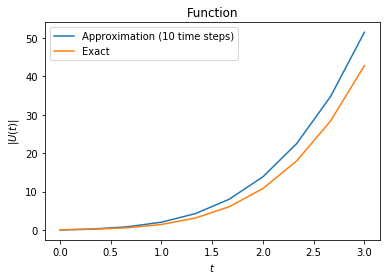

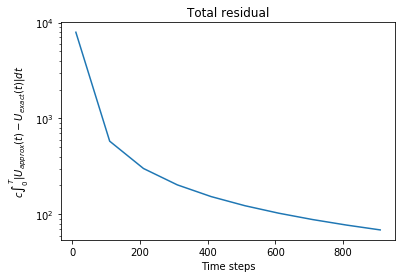

a: -4.72, \epsilon: -0.0695


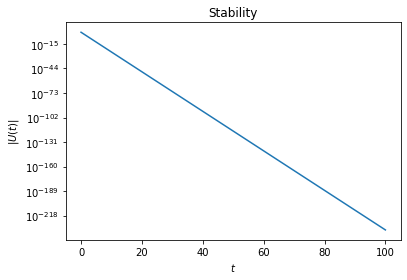

In [1013]:
test_scalar()

We can see that the approximation follows the exact solution and that the total residual decreases with $m$ as expected. In the stability test the magnitude decreases towards zero as expected.

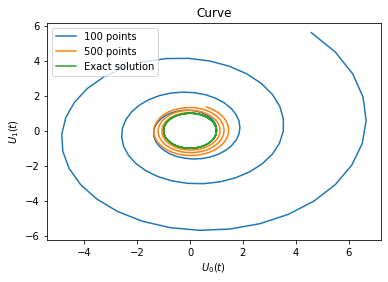

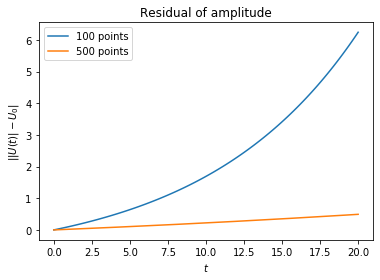

a: -0.313, \epsilon: 0.0884, \theta: 2.93


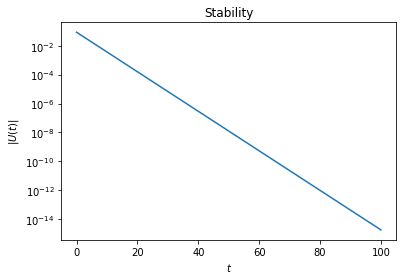

In [1014]:
test_system()

We can see that the approximation looks more similar to the exact solution the smaller the time step we use, as expected, and the residual increases faster as we decrease the time step. For stability we have convergence towards zero, and the horizontal line in the plot comes from loss of floating-point precision as $|U(t)|$ actually becomes 0.

## Stochastic differential equation

Mean X(t=T): 	4.91e-05
Exact X(t=T):	0.000177


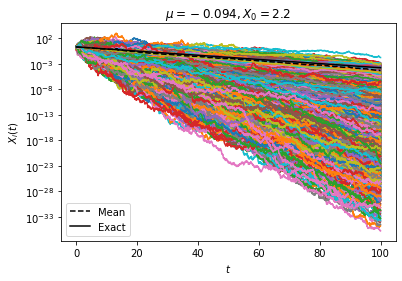

(4.905787764739688e-05, 0.00017655689805793755)

In [1015]:
import warnings
warnings.filterwarnings('ignore')
test_stochastic(simulations = 2000, plot = True)

The relative error in the estimation is rather low and the individual trajectories look reasonable. Note that the y-axis in the figure is logarithmic.

# **Discussion**

In [1016]:
def mini_test():
  mean, exact = test_stochastic(2000)
  return mean < exact
n = 100
print(f"Mean < Exact: {sum(mini_test() for _ in range(n)) / n:.0%}")

Mean < Exact: 98%


We conclude that the implementations behave as expected with regards to accuracy and stability. We do note, however, that even with repeated trials the mean of the simulated trajectories is always smaller than the expected value. This suggests either that there is some sort of bias in the algorithm or that the expected value has been miscalculated.